# Code to evaluate momentum and energy budgets in NeverWorld2

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.rcParams['font.sans-serif'] = "Latin Modern Roman"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

The momentum equation for layer $k$ is given by

\begin{align}
    \frac{\partial \mathbf{u}_k}{\partial t} + \left(\frac{{f} + {\zeta}_k}{h_k} \right) \hat{\mathbf{k}} \times \left( \mathbf{u}_k h_k \right) + \nabla K_k = - \sum_{i=1}^{k} g_{i-1/2}^\prime \nabla \eta_{i-1/2} + F_{hor} + F_{vert}
    \; 
    \label{eqn:u} \;,
\end{align}

where $\mathbf{u}_k$ is the horizontal velocity of layer $k$, $h_k$ is the layer thickness, and $\eta_k$ is the height of the upper surface of the layer relative to the reference height. 
$\zeta_k\hat{\mathbf{k}} \equiv \nabla \times \mathbf{u}_k$ and $K_k = \left(\mathbf{u}_k \cdot \mathbf{u}_k \right)/2$. $F_{hor}$ and $F_{vert}$ are the horizontal and vertical friction terms. In the model, the zonal and meridional components of the second term, $- \left(({f} + {\zeta}_k)/ h_k \right) \hat{\mathbf{k}} \times \left( \mathbf{u}_k h_k \right) - \nabla K_k$, are diagnosed as CAu and CAv. The first term on the RHS, the pressure force accelaration has two components: baroclinic (diagnosed as PFu and PFv) and barotropic (diagnosed as u_BT_accel and v_BT_accel). 

Note that the equation for KE is obtained by multipying the above equation by $\mathbf{u}_k h_k$, and so the terms in the KE budget have a one-to-one correspondence with the terms in the momentum budget. 

The runs that could be used for this analysis are run 20 (1/4 degree), run 26 (1/8 degree) and run 27 (1/16 degree). The model takes roughly 30000 days to equilibrate:

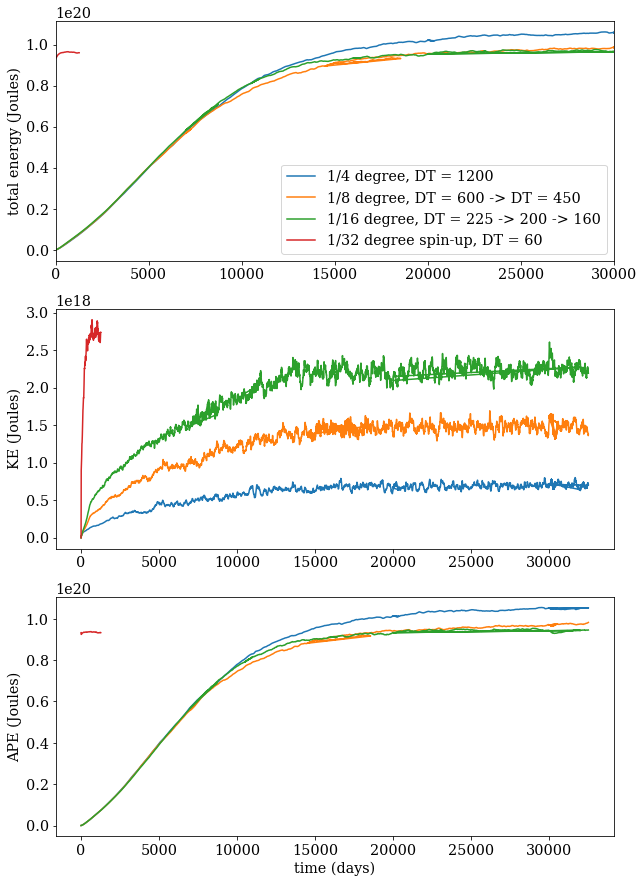

In [22]:
run = [20,26,28,33]
plt.figure(figsize=(10,15))
for i in range(len(run)):
    plt.subplot(3,1,1)
    os = xr.open_dataset('run%i/ocean.stats.nc' % run[i], decode_times=False)
    plt.plot(os.Time,os.En)
    plt.xlim((0,30000))
    plt.ylabel('total energy (Joules)') 
    plt.gca().legend(('1/4 degree, DT = 1200', '1/8 degree, DT = 600 -> DT = 450', '1/16 degree, DT = 225 -> 200 -> 160', '1/32 degree spin-up, DT = 60')) 
    plt.subplot(3,1,2)
    plt.plot(os.Time,os.KE.sum(axis=1))
    plt.ylabel('KE (Joules)')
    plt.subplot(3,1,3)
    plt.plot(os.Time,os.APE.sum(axis=1))
    plt.ylabel('APE (Joules)')
    plt.xlabel('time (days)')

plt.savefig('Energy_quarter_eighth_sixteenth_degree.png', dpi=200,bbox_inches='tight',pad_inches=0)
# DT is the time-step (in seconds) used to run the model
# The slight kink on the 1/8 degree run at 14500 days is because the time-step needed to be reduced because of high CFL with DT = 600 and needed a restart with DT = 450.

[5.94344967e+17 0.00000000e+00 0.00000000e+00]
[5.94344967e+17 1.31002227e+18 0.00000000e+00]
[5.94344967e+17 1.31002227e+18 2.01217877e+18]


(1.0, 64.0)

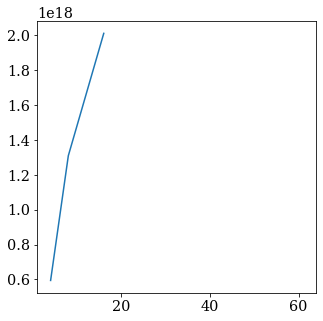

In [4]:
run = [20,26,28]
plt.figure(figsize=(5,5))
q = np.zeros(len(run))
for i in range(len(run)):
    os = xr.open_dataset('run%i/ocean.stats.nc' % run[i], decode_times=False)
    q[i] = os.KE.sel(Time=slice(11500,11800)).sum(axis=1).mean()
    print(q)
#     plt.gca().legend(('1/4 degree, DT = 1200', '1/8 degree, DT = 450', '1/16 degree, DT = 225')) 
    
plt.plot([4,8,16],q) 
plt.xlim((1,64))

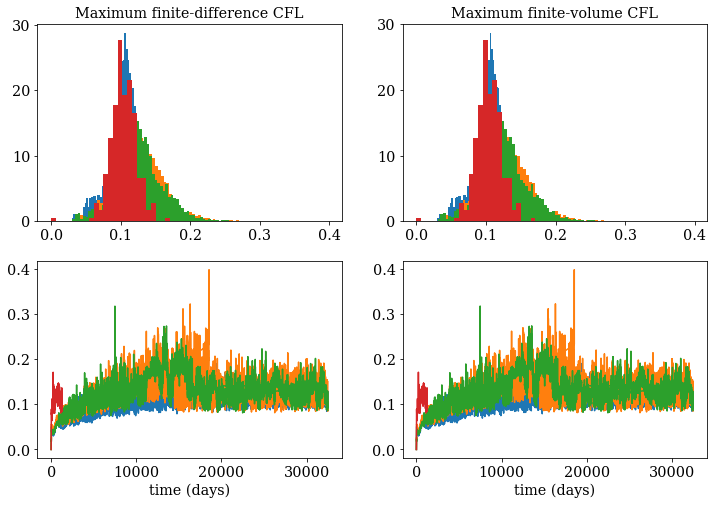

In [23]:
cfl_run = [20,26,28,33]

plt.figure(figsize=(12,8))

for i in range(len(cfl_run)):
    os = xr.open_dataset('run%i/ocean.stats.nc' % cfl_run[i], decode_times=False)
    plt.subplot(2,2,1)
    plt.hist(os.max_CFL_lin, bins='auto', density=True)
    plt.title('Maximum finite-difference CFL')

    plt.subplot(2,2,2)
    plt.hist(os.max_CFL_trans, bins='auto', density=True)
    plt.title('Maximum finite-volume CFL')
    
    plt.subplot(2,2,3)
    plt.plot(os.Time,os.max_CFL_lin)
    plt.xlabel('time (days)')

    plt.subplot(2,2,4)
    plt.plot(os.Time,os.max_CFL_trans)
    plt.xlabel('time (days)')
    
plt.savefig('CFL_quarter_eighth_sixteenth_degree.png', dpi=200,bbox_inches='tight',pad_inches=0)

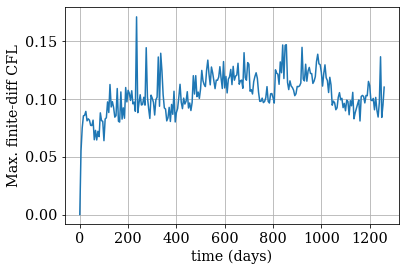

In [24]:
plt.plot(os.Time,os.max_CFL_lin)
plt.xlabel('time (days)')
plt.ylabel('Max. finite-diff CFL')
plt.grid()
plt.savefig('CFL_32_degree.png', dpi=200,bbox_inches='tight',pad_inches=0)

In [7]:
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400
run = 26 # change the run number here to evaluate different runs. Options are: 20, 26, 28, 33.
layer_no = 4 # the alternative is to do layer-averaged diagnostics but here I am looking at one layer in the interior

In [8]:
sn = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False)
av = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)
st = xr.open_dataset('run%i/static.nc' % run, decode_times=False)

xh and yh are the innner points (cell centers) and xq and yq are the outer points (cell edges)

In [9]:
xh = st.xh.values
yh = st.yh.values
xq = st.xq.values
yq = st.yq.values

In [10]:
av

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 480, xq: 481, yh: 1120, yq: 1121, zi: 16, zl: 15)
Coordinates:
  * xq          (xq) float64 0.0 0.125 0.25 0.375 0.5 ... 59.62 59.75 59.88 60.0
  * yh          (yh) float64 -69.94 -69.81 -69.69 -69.56 ... 69.69 69.81 69.94
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 3e+04 3.001e+04 3.001e+04 ... 3.049e+04 3.05e+04
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 59.69 59.81 59.94
  * yq          (yq) float64 -70.0 -69.88 -69.75 -69.62 ... 69.75 69.88 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    u           (time, zl, yh, xq) float32 ...
    v           (time, zl, yq, xh) float32 ...
    h           (time, zl, yh, xh) float32 ...
    e2          (time, zi, yh, xh) float32 ...
    uh          (time, zl, yh, xq) float32 ...
    vh          (time, zl, yq, xh) float32 ...
    PV          (time, zl, yq, xq) float32 ...
    dudt        (time, zl, yh, xq) float32 ...
    dvdt        (time, zl, yq, xh) float32 ...
    CAu         (time, zl, yh, xq) float32 ...
    CAv         (time, zl, yq, xh) float32 ...
    PFu         (time, zl, yh, xq) float32 ...
    PFv         (time, zl, yq, xh) float32 ...
    diffu       (time, zl, yh, xq) float32 ...
    diffv       (time, zl, yq, xh) float32 ...
    du_dt_visc  (time, zl, yh, xq) float32 ...
    dv_dt_visc  (time, zl, yq, xh) float32 ...
    u_BT_accel  (time, zl, yh, xq) float32 ...
    v_BT_accel  (time, zl, yq, xh) float32 ...
    KE          (time, zl, yh, xh) float32 ...
    dKE_dt      (time, zl, yh, xh) float32 ...
    PE_to_KE    (time, zl, yh, xh) float32 ...
    KE_BT       (time, zl, yh, xh) float32 ...
    KE_CorAdv   (time, zl, yh, xh) float32 ...
    KE_adv      (time, zl, yh, xh) float32 ...
    KE_visc     (time, zl, yh, xh) float32 ...
    KE_horvisc  (time, zl, yh, xh) float32 ...
    Rd_dx       (time, yh, xh) float32 ...
    Rd1         (time, yh, xh) float32 ...
    average_T1  (time) float64 ...
    average_T2  (time) float64 ...
    average_DT  (time) float64 ...
    time_bnds   (time, nv) float64 ...
Attributes:
    filename:          averages_00030002.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

## Momentum budget

Here we evaluate the meridional and zonal components of the momentum equation separately, and in a single layer.

In [11]:
term1_u = av.dudt.astype(float).values[-1,layer_no]
term2_u = av.CAu.astype(float).values[-1,layer_no]
term3_u = av.PFu.astype(float).values[-1,layer_no]
term4_u = av.u_BT_accel.astype(float).values[-1,layer_no] 
term5_u = av.diffu.astype(float).values[-1,layer_no]
term6_u = av.du_dt_visc.astype(float).values[-1,layer_no] #- av.taux.astype(float).values[-1] - av.taux_bot.astype(float).values[-1]

M_u = term1_u - term2_u - term3_u - term4_u - term5_u - term6_u # This is the zonal component of the residual from the momentum equation

In [12]:
term1_v = av.dvdt.astype(float).values[-1,layer_no]
term2_v = av.CAv.astype(float).values[-1,layer_no]
term3_v = av.PFv.astype(float).values[-1,layer_no]
term4_v = av.v_BT_accel.astype(float).values[-1,layer_no] 
term5_v = av.diffv.astype(float).values[-1,layer_no]
term6_v = av.dv_dt_visc.astype(float).values[-1,layer_no] #- av.tauy.astype(float).values[-1] - av.tauy_bot.astype(float).values[-1]

M_v = term1_v - term2_v - term3_v - term4_v - term5_v - term6_v # This is the meridional component of the residual from the momentum equation

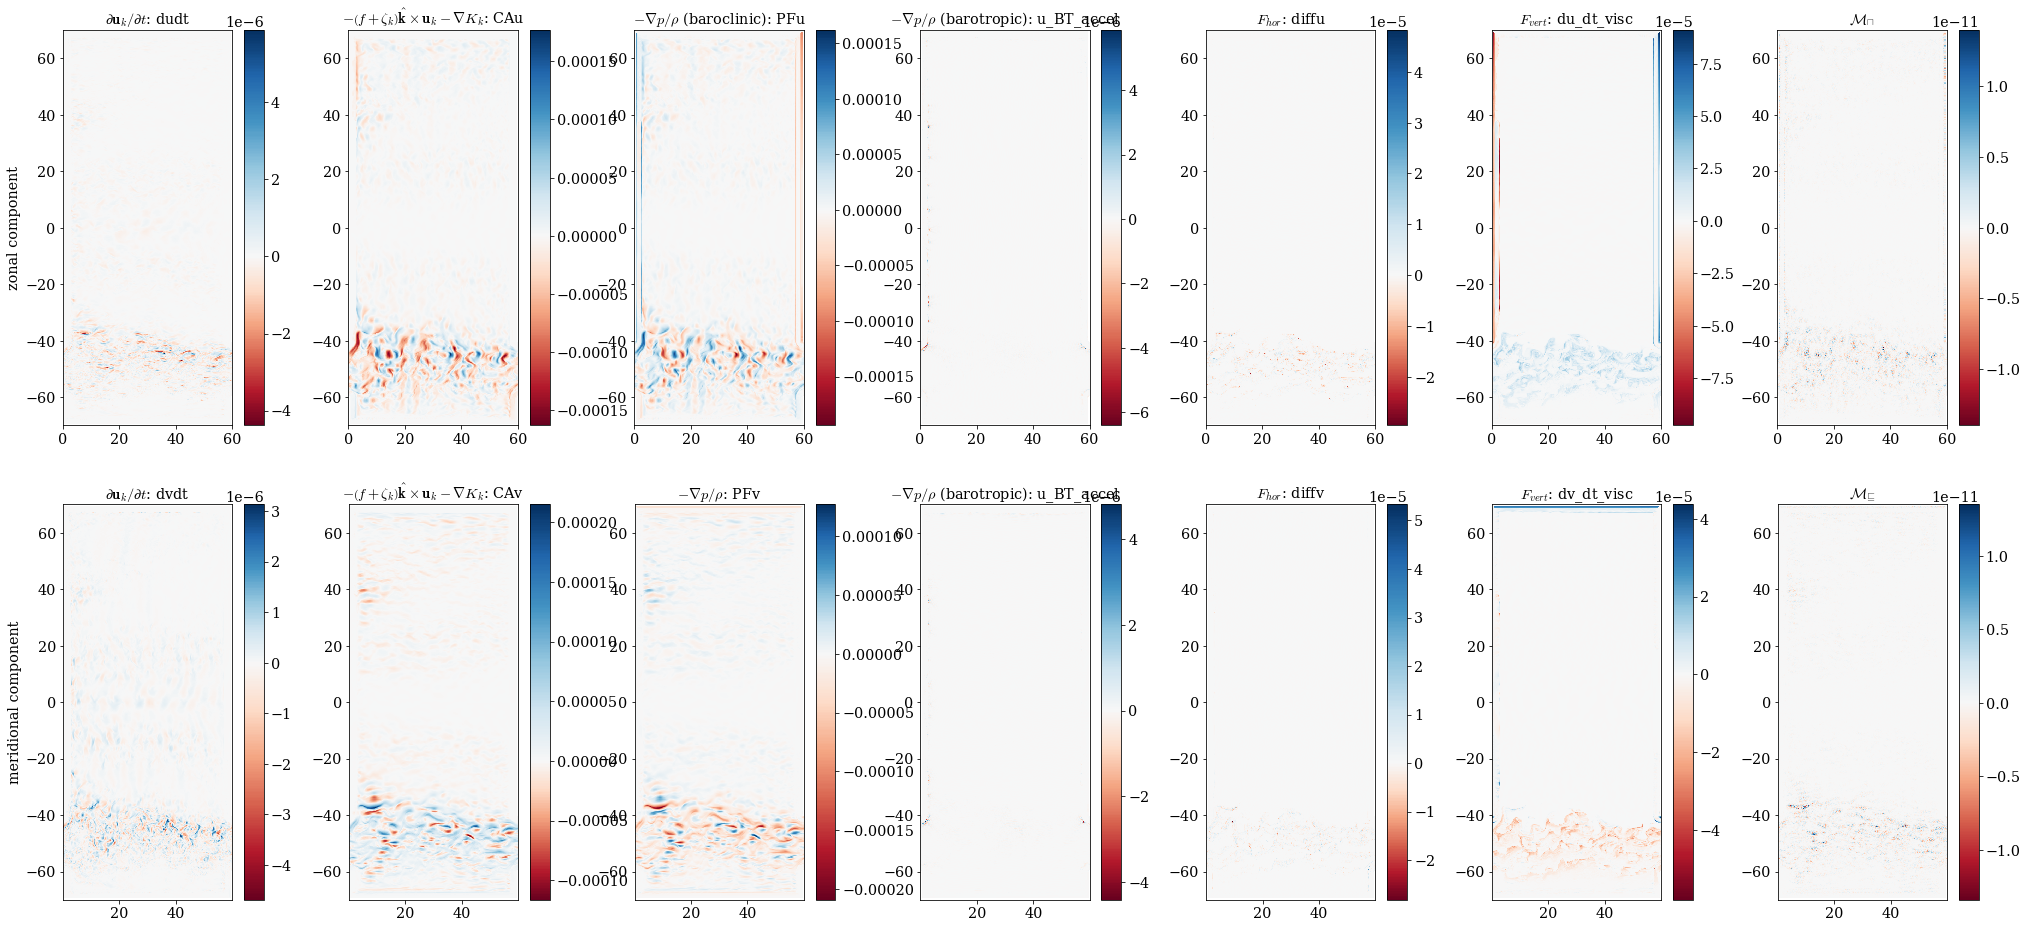

In [13]:
plt.figure(figsize=(35,16))
plt.subplot(2,7,1)
plt.pcolormesh(xq,yh,term1_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel('zonal component')
plt.title(r'$\partial \mathbf{u}_k /\partial t$: dudt')
plt.colorbar()

plt.subplot(2,7,2)
plt.pcolormesh(xq,yh,term2_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$- \left({f} + {\zeta}_k \right) \hat{\mathbf{k}} \times \mathbf{u}_k - \nabla K_k$: CAu')
plt.colorbar()

plt.subplot(2,7,3)
plt.pcolormesh(xq,yh,term3_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-\nabla p/\rho$ (baroclinic): PFu')
plt.colorbar()

plt.subplot(2,7,4)
plt.pcolormesh(xq,yh,term4_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-\nabla p/\rho$ (barotropic): u_BT_accel')
plt.colorbar()

plt.subplot(2,7,5)
plt.pcolormesh(xq,yh,term5_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$F_{hor}$: diffu')
plt.colorbar()

plt.subplot(2,7,6)
plt.pcolormesh(xq,yh,term6_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$F_{vert}$: du_dt_visc')
plt.colorbar()

plt.subplot(2,7,7)
plt.pcolormesh(xq,yh,M_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\mathcal{M_u}$')
plt.colorbar()

plt.subplot(2,7,8)
plt.pcolormesh(xh,yq,term1_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial \mathbf{u}_k /\partial t$: dvdt')
plt.ylabel('meridional component')
plt.colorbar()

plt.subplot(2,7,9)
plt.pcolormesh(xh,yq,term2_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$- \left({f} + {\zeta}_k \right) \hat{\mathbf{k}} \times \mathbf{u}_k - \nabla K_k$: CAv')
plt.colorbar()

plt.subplot(2,7,10)
plt.pcolormesh(xh,yq,term3_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.title(r'$-\nabla p/\rho$: PFv')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

plt.subplot(2,7,11)
plt.pcolormesh(xh,yq,term4_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-\nabla p/\rho$ (barotropic): u_BT_accel')
plt.colorbar()

plt.subplot(2,7,12)
plt.pcolormesh(xh,yq,term5_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$F_{hor}$: diffv')
plt.colorbar()

plt.subplot(2,7,13)
plt.pcolormesh(xh,yq,term6_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$F_{vert}$: dv_dt_visc')
plt.colorbar()

plt.subplot(2,7,14)
plt.pcolormesh(xh,yq,M_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\mathcal{M_v}$')
plt.colorbar()

plt.savefig('Momentum_end_time_%i_days_tau_5_days_layer_%i.png' % (end_time,layer_no), dpi=200,bbox_inches='tight',pad_inches=0)

Zoom in on the region where the residual is non-zero:

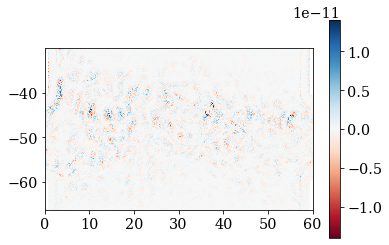

In [14]:
plt.pcolormesh(xq,yh[30:320],M_u[30:320,:],norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.savefig('zoom1.png', dpi=200,bbox_inches='tight',pad_inches=0)

## KE budget

Note that u and v are defined on slighlty different grids, whereas h and KE are defined at the cell center. Below, we write some functions that might be needed to interpolate from cell edges to cell centers.

In [15]:
def interp_u2_to_center(u):
    """Interpolate variable (like u or u^2) to xh and yh when it is defined at xq and yh points"""
    n,layers,ly,lx_p_1 = u.shape
    lx = lx_p_1 - 1
    u_center = np.zeros((n,layers,ly,lx))
    u_center[:,:,:,:] = (u[:,:,:,:-1] + u[:,:,:,1:])/2
    u_center[:,:,:,0] = (u[:,:,:,0] + u[:,:,:,-1])/2 # periodic
    u_center[:,:,:,-1] = (u[:,:,:,0] + u[:,:,:,-1])/2 # periodic
    
    return u_center
    
def interp_v2_to_center(v):
    """Interpolate variable (like v or v^2) to xh and yh when it is defined at xh and yq points"""
    n,layers,ly_p_1,lx = v.shape
    ly = ly_p_1 - 1
    v_center = np.zeros((n,layers,ly,lx))
    v_center[:,:,:,:] = (v[:,:,:-1,:] + v[:,:,1:,:])/2
    
    return v_center

def interp_to_center(A): 
    """Interpolate a general variable that is defined at xq and yq to xh and yh points"""
    n,layers,ly_p_1,lx_p_1 = A.shape
    ly = ly_p_1 - 1
    lx = lx_p_1 - 1
    A_center = np.zeros((n,layers,ly,lx))
    A_center[:,:,:,:] = (A[:,:,:-1,:-1] + A[:,:,1:,1:])/2 
    
    return A_center

In [16]:
term1_E = av.dKE_dt.astype(float).values[-1,layer_no]
term2_E = av.KE_CorAdv.astype(float).values[-1,layer_no]
term3_E = av.PE_to_KE.astype(float).values[-1,layer_no]
term4_E = av.KE_BT.astype(float).values[-1,layer_no]
term5_E = av.KE_visc.astype(float).values[-1,layer_no]
term6_E = av.KE_horvisc.astype(float).values[-1,layer_no]

In [17]:
E = term1_E  - (term2_E + term3_E + term4_E + term5_E + term6_E) # This is the residual of KE tendency, which should be zero.

2.1853452381037641e-10


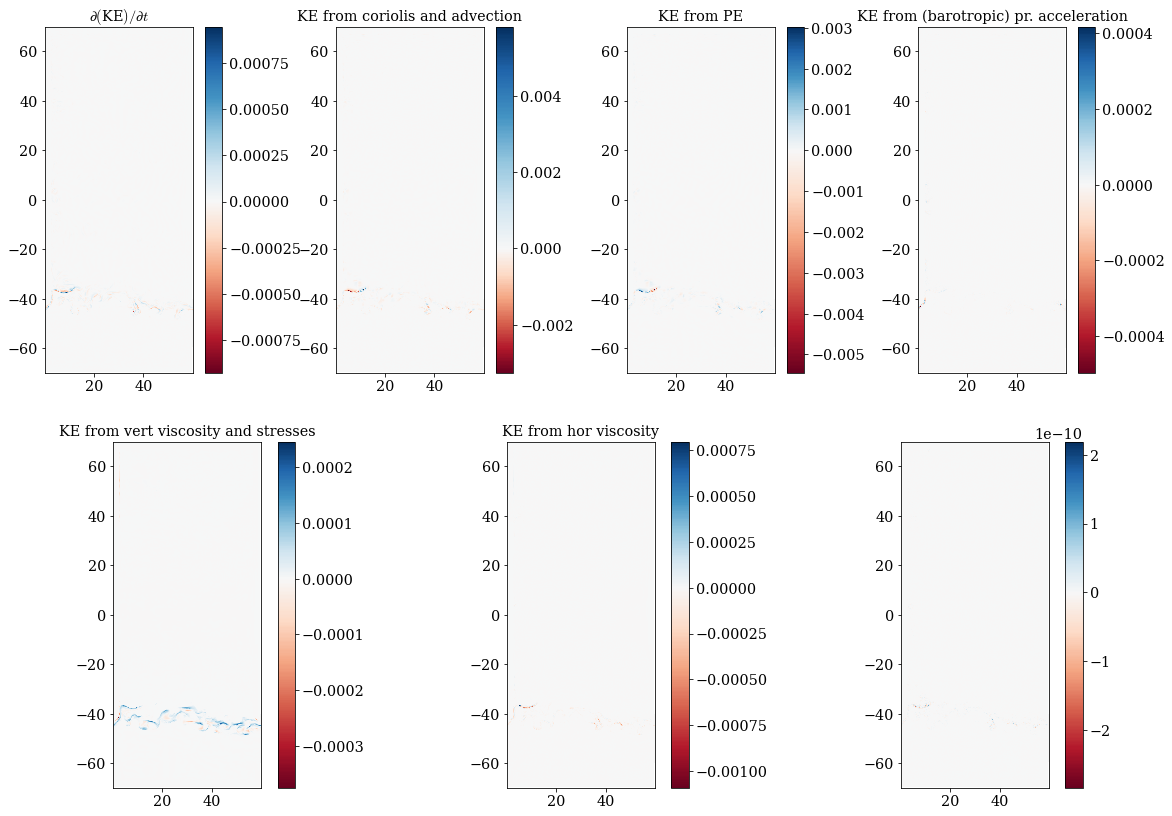

In [18]:
plt.figure(figsize=(20,14))

plt.subplot(2,4,1)
plt.pcolormesh(xh,yh,term1_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial ($KE$)/\partial t$')
plt.colorbar()

plt.subplot(2,4,2)
plt.pcolormesh(xh,yh,term2_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from coriolis and advection')
plt.colorbar()

plt.subplot(2,4,3)
plt.pcolormesh(xh,yh,term3_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from PE')
plt.colorbar()

plt.subplot(2,4,4)
plt.pcolormesh(xh,yh,term4_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from (barotropic) pr. acceleration')
plt.colorbar()

# plt.subplot(2,4,4)
# plt.pcolormesh(xh,yh,term4_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.title(r'KE from (baroclinic) pr. acceleration')
# plt.colorbar()

plt.subplot(2,3,4)
plt.pcolormesh(xh,yh,term5_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from vert viscosity and stresses')
plt.colorbar()

plt.subplot(2,3,5)
plt.pcolormesh(xh,yh,term6_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from hor viscosity')
plt.colorbar()

plt.subplot(2,3,6)
plt.pcolormesh(xh,yh,E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

print(np.nanmax(E))
plt.savefig('KE_end_time_%i_days_tau_%i_days_layer_%i.png' % (end_time,tau/86400,layer_no), dpi=200,bbox_inches='tight',pad_inches=0)

Again zoom in on relevant regions where the residual is non-zero:

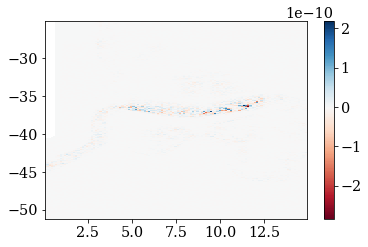

In [19]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,6)
plt.pcolormesh(xh[:120],yh[150:360],E[150:360,:120],norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.colorbar()
# plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('zoom2.png', dpi=200,bbox_inches='tight',pad_inches=0)

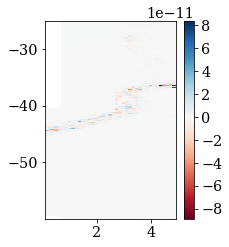

In [20]:
plt.figure(figsize=(10,8))
plt.subplot(2,3,6)
plt.pcolormesh(xh[:40],yh[80:360],E[80:360,:40],norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.colorbar()
# plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('zoom3.png', dpi=200,bbox_inches='tight',pad_inches=0)

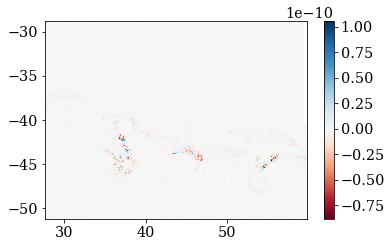

In [21]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,6)
plt.pcolormesh(xh[220:],yh[150:330],E[150:330,220:],norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.colorbar()
# plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('zoom4.png', dpi=200,bbox_inches='tight',pad_inches=0)